# Project 1: Exploratory Data Analysis
Diabetes Data

First Name, Last Name

## Declaration

**The source of the data is the *The Juvenile Diabetes Research Foundation 
Continuous Glucose Monitoring Study Group*, but the analyses, content 
and conclusions presented herein are solely the responsibility of the authors 
and have not been reviewed or approved by the aforementioned study ownwers.**

# Data Notes
## Initial questions
- Does data variance, ranges, etc change from un/blinded groups or over time with cgm?
- Do pumps result in more consistent glucose levels?
- Does caregiver age/education correlate to outcomes?
- Can timeseries data predict a hyper/hypo event?


## Edge cases
-


## Caveats / Assumptions
- 

# Python Imports

In [1]:
%load_ext autoreload

In [2]:
import dask.dataframe as dd
import glob

In [3]:
%autoreload 2

In [4]:
import pandas as pd # ensure v = 0.24 !pip install --upgrade pandas 
import numpy as np
import datetime as dt

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap,LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

In [6]:
import os
from pathlib import Path
import pdb

In [7]:
import dask

In [8]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [9]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [10]:
sns.set_style('darkgrid')

In [11]:
sns.set_context('talk')

# 1. Data Import

In [12]:
# Listing all data table files
directory = os.fsencode('data/')

r = []
for root, dirs, files in os.walk(directory):
    for name in files:
        r.append(os.path.join(root, name))

file_list = [f.decode('UTF-8') for f in r if 'DS_Store' not in str(f)]
file_list

['data/aaReadMe.rtf',
 'data/tblALabHbA1c.csv',
 'data/tblAPtSummary.csv',
 'data/.ipynb_checkpoints\\aaReadMe-checkpoint.rtf',
 'data/.ipynb_checkpoints\\tblALabHbA1c-checkpoint.csv',
 'data/.ipynb_checkpoints\\tblAPtSummary-checkpoint.csv',
 'data/CGM_data\\Control_group\\tblADataRTCGM_Blind_ControlGroup.csv',
 'data/CGM_data\\Control_group\\tblADataRTCGM_Unblinded_ControlGroup_1.csv',
 'data/CGM_data\\Control_group\\tblADataRTCGM_Unblinded_ControlGroup_2.csv',
 'data/CGM_data\\Control_group\\tblADataRTCGM_Unblinded_ControlGroup_3.csv',
 'data/CGM_data\\Control_group\\tblADataRTCGM_Unblinded_ControlGroup_4.csv',
 'data/CGM_data\\Control_group\\tblADataRTCGM_Unblinded_ControlGroup_5.csv',
 'data/CGM_data\\Control_group\\.ipynb_checkpoints\\tblADataRTCGM_Blind_ControlGroup-checkpoint.csv',
 'data/CGM_data\\Control_group\\.ipynb_checkpoints\\tblADataRTCGM_Unblinded_ControlGroup_1-checkpoint.csv',
 'data/CGM_data\\Control_group\\.ipynb_checkpoints\\tblADataRTCGM_Unblinded_ControlGroup_2-

In [13]:
# Import patient summary & demographics
pt_summary_orig = pd.read_csv('data/tblAPtSummary.csv')
pt_summary = pt_summary_orig.copy(deep=True)
pt_summary.head()

,RecID,PtID,Gender,AgeAsOfRandDt,Race,Ethnicity,Height,Weight,DurDiabetes,InsulinModality,NumSevHypo,HGMReadAvg,EduCareGvrP,EduCareGvrPEdu,RandDt,TxGroup
0,1,307,M,46,White,Not Hispanic or Latino,167.8,93.4,31.0,Pump,0,NaN,Subject,Bachelors,1/9/2000 13:42,Control
1,2,258,M,18,White,Not Hispanic or Latino,193.5,97.1,10.4,Pump,0,NaN,Mother,Bachelors,1/15/2000 14:26,RT-CGM
2,3,309,M,16,White,Not Hispanic or Latino,174.0,73.0,6.1,Pump,0,NaN,Mother,Bachelors,1/14/2000 9:57,Control
3,4,344,F,69,White,Not Hispanic or Latino,162.5,64.7,14.8,Pump,0,NaN,Subject,Masters,1/20/2000 11:06,Control
4,5,350,F,13,White,Not Hispanic or Latino,165.1,62.3,7.1,Pump,0,NaN,Father,Associates,1/14/2000 17:28,RT-CGM


In [14]:
# Examine single RTCGM file
cgm_test = pd.read_csv('data/CGM_data/Control_group/tblADataRTCGM_Unblinded_ControlGroup_5.csv',
                       parse_dates=['DeviceDtTm'])
cgm_test.head()

,RecID,PtID,DeviceDtTm,Glucose
0,9306853,463,2001-01-21 00:00:00,246
1,9306854,463,2001-01-21 00:05:00,242
2,9306855,463,2001-01-21 00:10:00,238
3,9306856,463,2001-01-21 00:15:00,232
4,9306857,463,2001-01-21 00:20:00,234


In [15]:
cgm_summary_test = cgm_test.merge(pt_summary,on='PtID',how='left')

In [16]:
cgm_summary_test.head()

,RecID_x,PtID,DeviceDtTm,Glucose,RecID_y,Gender,AgeAsOfRandDt,Race,Ethnicity,Height,Weight,DurDiabetes,InsulinModality,NumSevHypo,HGMReadAvg,EduCareGvrP,EduCareGvrPEdu,RandDt,TxGroup
0,9306853,463,2001-01-21 00:00:00,246,290,M,33,White,Not Hispanic or Latino,171.5,72.8,30.8,Pump,0,4.0,Subject,Bachelors,7/21/2000 12:49,Control
1,9306854,463,2001-01-21 00:05:00,242,290,M,33,White,Not Hispanic or Latino,171.5,72.8,30.8,Pump,0,4.0,Subject,Bachelors,7/21/2000 12:49,Control
2,9306855,463,2001-01-21 00:10:00,238,290,M,33,White,Not Hispanic or Latino,171.5,72.8,30.8,Pump,0,4.0,Subject,Bachelors,7/21/2000 12:49,Control
3,9306856,463,2001-01-21 00:15:00,232,290,M,33,White,Not Hispanic or Latino,171.5,72.8,30.8,Pump,0,4.0,Subject,Bachelors,7/21/2000 12:49,Control
4,9306857,463,2001-01-21 00:20:00,234,290,M,33,White,Not Hispanic or Latino,171.5,72.8,30.8,Pump,0,4.0,Subject,Bachelors,7/21/2000 12:49,Control


In [17]:
BASE_DIR = './data/CGM_data'

ctrl_blind = os.path.join(BASE_DIR, 'Control_group/tblADataRTCGM_Blind_ControlGroup.csv')
ctrl_blind_df = pd.read_csv(ctrl_blind).merge(pt_summary,on='PtID',how='left')

ctrl_unblind = glob.glob(BASE_DIR + '/Control_group/' + '*Unblinded*')
ctrl_unblind_list = [pd.read_csv(file) for file in ctrl_unblind]
ctrl_unblind_df = pd.concat(ctrl_unblind_list).merge(pt_summary,on='PtID',how='left')

trmt_blind_baseline = os.path.join(BASE_DIR,'RTCGM_group/tblADataRTCGM_Blind_Baseline.csv')
trmt_blind_baseline_df = pd.read_csv(trmt_blind_baseline).merge(pt_summary,on='PtID',how='left')

trmt_unblind = glob.glob(BASE_DIR + '/RTCGM_group/' + '*Unblinded*')
trmt_unblind_list = [pd.read_csv(file) for file in trmt_unblind]
trmt_unblind_df = pd.concat(trmt_unblind_list).merge(pt_summary,on='PtID',how='left')

all_df = [ctrl_blind_df, ctrl_unblind_df, trmt_blind_baseline_df, trmt_unblind_df]

#### Import CGM Data

In [18]:
def merge_summary(df):
    df = df.merge(pt_summary,on='PtID',how='left')
    
for df in all_df:
    merge_summary(df)

In [19]:
trmt_unblind_df.head()

,RecID_x,PtID,DeviceDtTm,Glucose,RecID_y,Gender,AgeAsOfRandDt,Race,Ethnicity,Height,Weight,DurDiabetes,InsulinModality,NumSevHypo,HGMReadAvg,EduCareGvrP,EduCareGvrPEdu,RandDt,TxGroup
0,2802764,1,2000-08-16 15:25:00.000000,130,228,F,36,White,Not Hispanic or Latino,165.5,80.8,29.8,Pump,0,10.0,Subject,Masters,8/6/2000 12:39,RT-CGM
1,2802765,1,2000-08-16 15:20:00.000000,124,228,F,36,White,Not Hispanic or Latino,165.5,80.8,29.8,Pump,0,10.0,Subject,Masters,8/6/2000 12:39,RT-CGM
2,2802766,1,2000-08-16 13:15:00.000000,172,228,F,36,White,Not Hispanic or Latino,165.5,80.8,29.8,Pump,0,10.0,Subject,Masters,8/6/2000 12:39,RT-CGM
3,2802767,1,2000-08-16 13:10:00.000000,170,228,F,36,White,Not Hispanic or Latino,165.5,80.8,29.8,Pump,0,10.0,Subject,Masters,8/6/2000 12:39,RT-CGM
4,2802768,1,2000-08-16 13:05:00.000000,168,228,F,36,White,Not Hispanic or Latino,165.5,80.8,29.8,Pump,0,10.0,Subject,Masters,8/6/2000 12:39,RT-CGM


In [20]:
trmt_unblind_df.describe()

,RecID_x,PtID,Glucose,RecID_y,AgeAsOfRandDt,Height,Weight,DurDiabetes,HGMReadAvg
count,1.168219e+07,1.168219e+07,1.168219e+07,1.168219e+07,1.168219e+07,1.168219e+07,1.168219e+07,1.168219e+07,9.486757e+06
mean,8.476120e+06,2.483240e+02,1.560357e+02,2.395563e+02,2.719620e+01,1.654488e+02,6.680797e+01,1.541854e+01,6.294140e+00
std,5.306884e+06,1.424011e+02,6.547661e+01,1.453277e+02,1.576215e+01,1.456692e+01,2.013349e+01,1.263941e+01,2.470207e+00
min,1.000000e+00,1.000000e+00,1.200000e+01,2.000000e+00,8.000000e+00,1.265000e+02,2.690000e+01,1.000000e+00,1.000000e+00
25%,3.809625e+06,1.160000e+02,1.080000e+02,9.600000e+01,1.300000e+01,1.585000e+02,5.330000e+01,6.200000e+00,4.000000e+00
50%,7.858010e+06,2.450000e+02,1.440000e+02,2.390000e+02,2.300000e+01,1.670000e+02,6.710000e+01,1.120000e+01,6.000000e+00
75%,1.280272e+07,3.630000e+02,1.920000e+02,3.630000e+02,4.000000e+01,1.752000e+02,8.180000e+01,2.180000e+01,8.000000e+00
max,1.892340e+07,5.030000e+02,6.540000e+02,4.910000e+02,7.200000e+01,1.935000e+02,1.114000e+02,6.260000e+01,1.400000e+01


In [21]:
trmt_unblind_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11682189 entries, 0 to 11682188
Data columns (total 19 columns):
 #   Column           Dtype  
---  ------           -----  
 0   RecID_x          int64  
 1   PtID             int64  
 2   DeviceDtTm       object 
 3   Glucose          int64  
 4   RecID_y          int64  
 5   Gender           object 
 6   AgeAsOfRandDt    int64  
 7   Race             object 
 8   Ethnicity        object 
 9   Height           float64
 10  Weight           float64
 11  DurDiabetes      float64
 12  InsulinModality  object 
 13  NumSevHypo       object 
 14  HGMReadAvg       float64
 15  EduCareGvrP      object 
 16  EduCareGvrPEdu   object 
 17  RandDt           object 
 18  TxGroup          object 
dtypes: float64(4), int64(5), object(10)
memory usage: 1.7+ GB


In [24]:
ctrl_blind_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 710838 entries, 0 to 710837
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   RecID_x          710838 non-null  int64  
 1   PtID             710838 non-null  int64  
 2   DeviceDtTm       710838 non-null  object 
 3   Glucose          710838 non-null  int64  
 4   RecID_y          710838 non-null  int64  
 5   Gender           710838 non-null  object 
 6   AgeAsOfRandDt    710838 non-null  int64  
 7   Race             710838 non-null  object 
 8   Ethnicity        710838 non-null  object 
 9   Height           710838 non-null  float64
 10  Weight           710838 non-null  float64
 11  DurDiabetes      710838 non-null  float64
 12  InsulinModality  710838 non-null  object 
 13  NumSevHypo       710838 non-null  object 
 14  HGMReadAvg       609362 non-null  float64
 15  EduCareGvrP      710838 non-null  object 
 16  EduCareGvrPEdu   710838 non-null  obje

In [25]:
cols = ctrl_blind_df.columns
for c in cols:
    print(c + ' number of nulls:', ctrl_blind_df[c].isna().sum()) 

RecID_x number of nulls: 0
PtID number of nulls: 0
DeviceDtTm number of nulls: 0
Glucose number of nulls: 0
RecID_y number of nulls: 0
Gender number of nulls: 0
AgeAsOfRandDt number of nulls: 0
Race number of nulls: 0
Ethnicity number of nulls: 0
Height number of nulls: 0
Weight number of nulls: 0
DurDiabetes number of nulls: 0
InsulinModality number of nulls: 0
NumSevHypo number of nulls: 0
HGMReadAvg number of nulls: 101476
EduCareGvrP number of nulls: 0
EduCareGvrPEdu number of nulls: 0
RandDt number of nulls: 0
TxGroup number of nulls: 0


# 2. Data Quality Check

#### Findings:

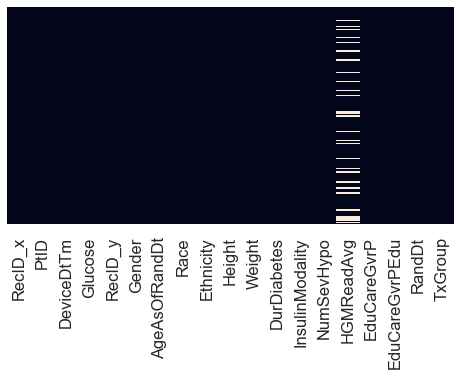

In [26]:
# Check for nulls (white lines in plot)
fig,ax = plt.subplots(figsize=(8,4))
sns.heatmap(trmt_unblind_df.isnull(),cbar=False,ax=ax)
ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
null_vals = trmt_unblind_df.HGMReadAvg.isna().sum()
total = trmt_unblind_df.HGMReadAvg.count()

print(f'Percent null values: {round(null_vals/total, 2)}') 

Percent null values: 0.23


In [28]:
# def drop_col(df, col_list):
#     df = df.drop(col_list, axis=1)
    
# drop_col(cgm_control_summary, ['HGMReadAvg'])
# drop_col(cgm_treatment_summary, ['HGMReadAvg'])

### Convert strings to datetime

In [29]:
def str2dt(df, col_list):
    for i in col_list:
        df[i] = pd.to_datetime(df[i])
        
time_cols = ['DeviceDtTm', 'RandDt']
for df in all_df:
    str2dt(df, time_cols)

In [30]:
trmt_unblind_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11682189 entries, 0 to 11682188
Data columns (total 19 columns):
 #   Column           Dtype         
---  ------           -----         
 0   RecID_x          int64         
 1   PtID             int64         
 2   DeviceDtTm       datetime64[ns]
 3   Glucose          int64         
 4   RecID_y          int64         
 5   Gender           object        
 6   AgeAsOfRandDt    int64         
 7   Race             object        
 8   Ethnicity        object        
 9   Height           float64       
 10  Weight           float64       
 11  DurDiabetes      float64       
 12  InsulinModality  object        
 13  NumSevHypo       object        
 14  HGMReadAvg       float64       
 15  EduCareGvrP      object        
 16  EduCareGvrPEdu   object        
 17  RandDt           datetime64[ns]
 18  TxGroup          object        
dtypes: datetime64[ns](2), float64(4), int64(5), object(8)
memory usage: 1.7+ GB


In [32]:
cat_columns = list(trmt_unblind_df.select_dtypes(include='object'))
for col in cat_columns:
    print(col, trmt_unblind_df[col].unique())

Gender ['F' 'M']
Race ['White' 'More than one race' 'Unknown/not reported'
 'Black/African American' 'American Indian/Alaskan Native']
Ethnicity ['Not Hispanic or Latino' 'Hispanic or Latino' 'Unknown/not reported']
InsulinModality ['Pump' 'Injections']
NumSevHypo ['0' '2' '1' '>3' '3']
EduCareGvrP ['Subject' 'Mother' 'Father' 'Spouse']
EduCareGvrPEdu ['Masters' 'Bachelors' 'Associates' 'Professional' '12' '11']
TxGroup ['RT-CGM']


# 3. EDA - Feature Exploration for Driving Factors & Relationship to Outcome
## Potential feature engineering targets:
### BMI, Morning/afternoon/night, day of week, 

In [33]:
# Adds BMI and BMI classification columns 
def bmiClass(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'healthy_weight'
    elif bmi < 30:
        return 'overweight'
    else:
        return 'obese'
def addBMICol(df):
    df['bmi'] = df.apply(lambda x: x['Weight'] / (x['Height']/100)**2, axis=1)
    df['bmi_class'] = df.apply(lambda x: bmiClass(x['bmi']), axis=1)
    
for df in all_df:
    addBMICol(df)

trmt_unblind_df.bmi_class.head()

0    overweight
1    overweight
2    overweight
3    overweight
4    overweight
Name: bmi_class, dtype: object

In [34]:
# Adds day of the week column
def addDay(df):
    df['day'] = df.DeviceDtTm.dt.day_name()

for df in all_df:
    addDay(df)

trmt_unblind_df.day.head()

0    Wednesday
1    Wednesday
2    Wednesday
3    Wednesday
4    Wednesday
Name: day, dtype: object

In [35]:
# Adds time of day column
def hour2time(hour):
    if hour < 6:
        return 'night'
    elif hour < 12:
        return 'morning'
    elif hour < 18:
        return 'afternoon'
    else:
        return 'evening'
    
def dt2TimeOfDay(df, col):
    df['time_of_day'] = df.apply(lambda x: hour2time(x[col].hour) , axis=1)

for df in all_df:
    dt2TimeOfDay(df, 'DeviceDtTm')
    
trmt_unblind_df[['DeviceDtTm', 'time_of_day']].head()

,DeviceDtTm,time_of_day
0,2000-08-16 15:25:00,afternoon
1,2000-08-16 15:20:00,afternoon
2,2000-08-16 13:15:00,afternoon
3,2000-08-16 13:10:00,afternoon
4,2000-08-16 13:05:00,afternoon


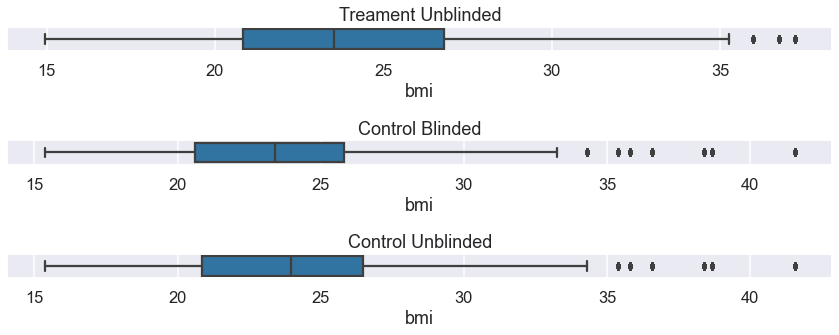

In [38]:
# BMI data is static (colllected one time) whereas glucose is constantly changing
# It would be more accurate if BMI was reported more frequently

fig, axes = plt.subplots(3, 1, figsize=(12,5))
sns.boxplot(x=trmt_unblind_df.bmi, ax=axes[0]).set(title='Treament Unblinded')
sns.boxplot(x=ctrl_blind_df.bmi, ax=axes[1]).set(title='Control Blinded')
sns.boxplot(x=ctrl_unblind_df.bmi, ax=axes[2]).set(title='Control Unblinded')
fig.tight_layout()

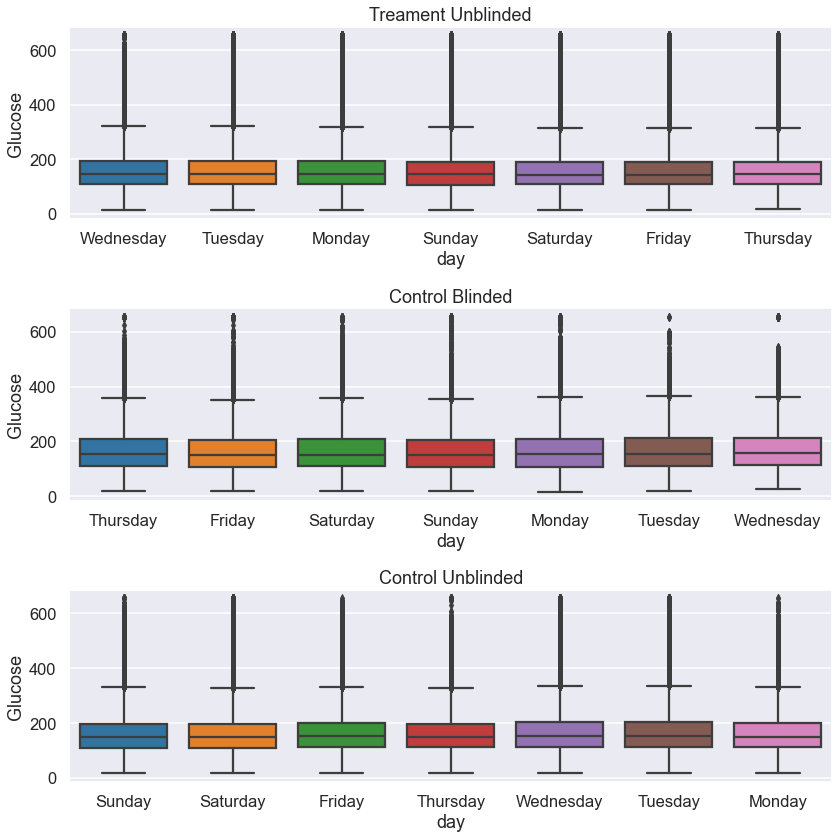

In [41]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(x="day", y="Glucose", data=trmt_unblind_df, ax=ax[0]).set(title='Treament Unblinded')
sns.boxplot(x="day", y="Glucose", data=ctrl_blind_df, ax=ax[1]).set(title='Control Blinded')
sns.boxplot(x="day", y="Glucose", data=ctrl_unblind_df, ax=ax[2]).set(title='Control Unblinded')
fig.tight_layout()

[Text(0.5, 1.0, 'Control Unblinded')]

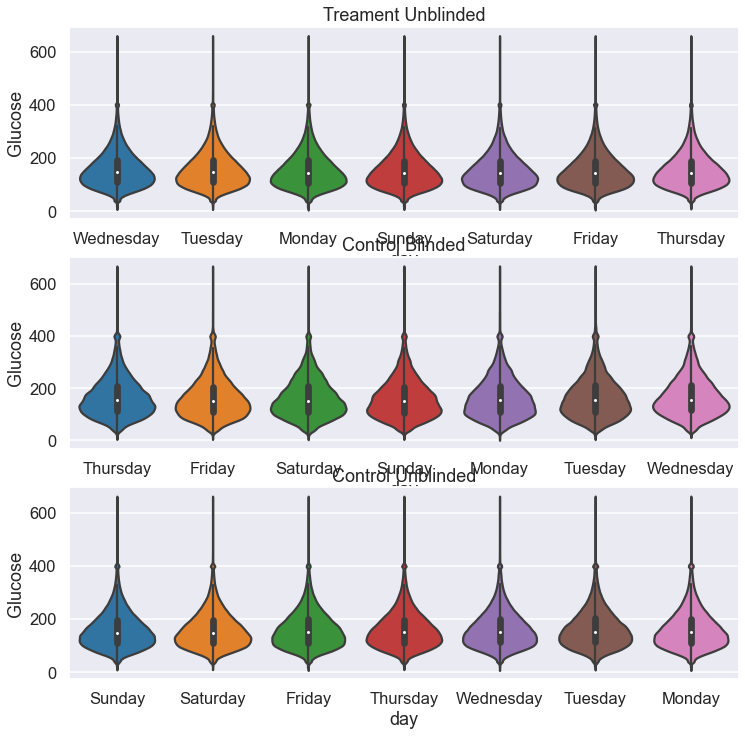

In [43]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
sns.violinplot(x="day", y="Glucose", data=trmt_unblind_df, ax=ax[0]).set(title='Treament Unblinded')
sns.violinplot(x="day", y="Glucose", data=ctrl_blind_df, ax=ax[1]).set(title='Control Blinded')
sns.violinplot(x="day", y="Glucose", data=ctrl_unblind_df, ax=ax[2]).set(title='Control Unblinded')

[Text(0.5, 1.0, 'Control Unblind')]

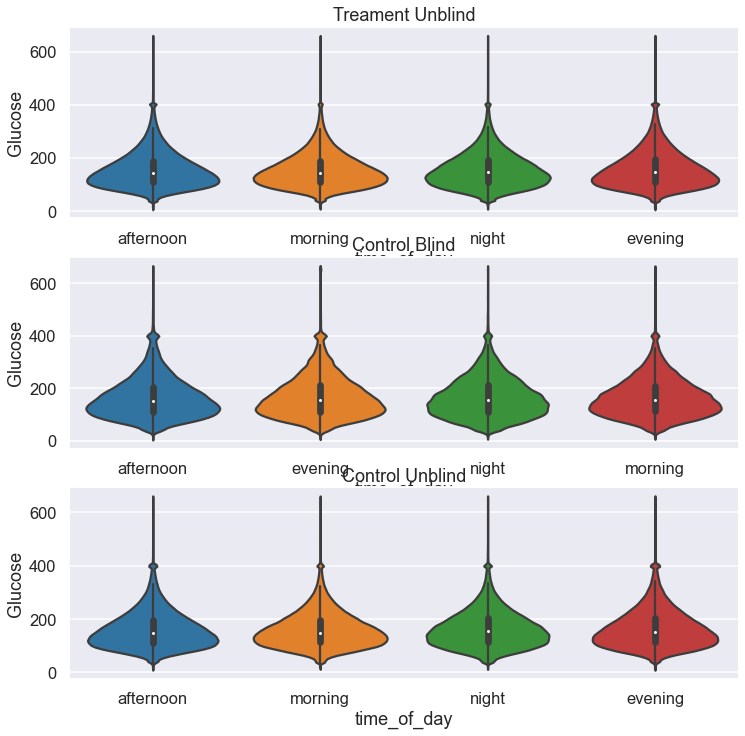

In [44]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
sns.violinplot(x="time_of_day", y="Glucose", data=trmt_unblind_df, ax=ax[0]).set(title='Treament Unblind')
sns.violinplot(x="time_of_day", y="Glucose", data=ctrl_blind_df, ax=ax[1]).set(title='Control Blind')
sns.violinplot(x="time_of_day", y="Glucose", data=ctrl_unblind_df, ax=ax[2]).set(title='Control Unblind')

[Text(0.5, 1.0, 'Control Unblind')]

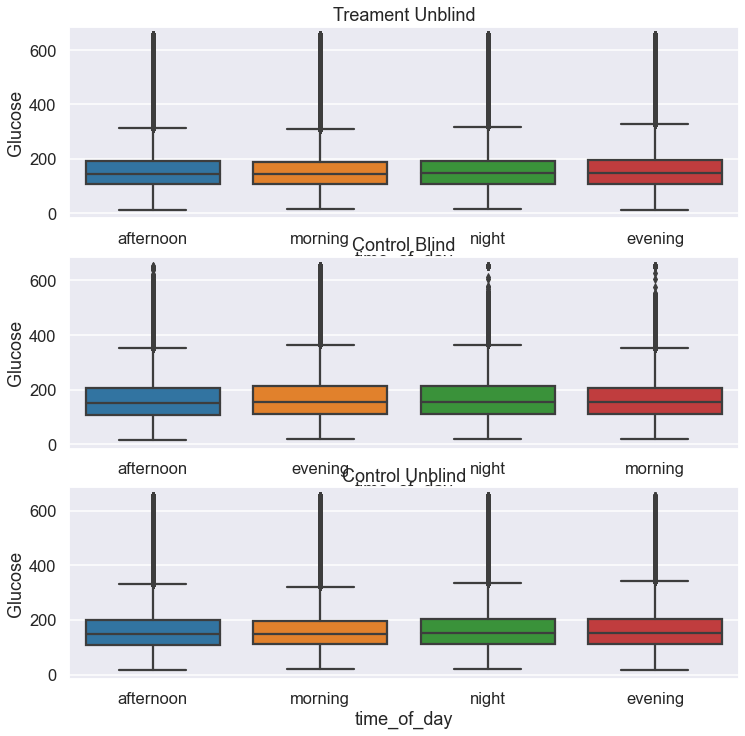

In [46]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
sns.boxplot(x="time_of_day", y="Glucose", data=trmt_unblind_df, ax=ax[0]).set(title='Treament Unblind')
sns.boxplot(x="time_of_day", y="Glucose", data=ctrl_blind_df, ax=ax[1]).set(title='Control Blind')
sns.boxplot(x="time_of_day", y="Glucose", data=ctrl_unblind_df, ax=ax[2]).set(title='Control Unblind')

In [ ]:
def time_from_start(df):
    df_pt_start_dt = df.groupby(['PtID'])['DeviceDtTm'].min().rename('pt_start_dt').reset_index()
    df = df.merge(df_pt_start_dt, on='PtID', how='left')
    df['elapsed_days'] = df.apply(lambda x: x['DeviceDtTm'] - x['pt_start_dt'], axis=1)
    
# time_from_start(ctrl_blind_df)
# ctrl_unblind_pt_start_dt = ctrl_unblind_df
# trmt_blind_baseline_pt_start_dt = trmt_blind_baseline_df
# trmt_unblind_pt_start_dt = trmt_unblind_df

In [52]:
# for df in all_df:
#del df_pt_start_dt_cb, df_pt_start_dt_cu, df_pt_start_dt_tb, df_pt_start_dt_tu
df_pt_start_dt_cb = ctrl_blind_df.groupby(['PtID'])['DeviceDtTm'].min().rename('pt_start_dt').reset_index()
ctrl_blind_df = ctrl_blind_df.merge(df_pt_start_dt_cb, on='PtID', how='left')
ctrl_blind_df['elapsed_weeks'] = ctrl_blind_df.apply(lambda x: (x['DeviceDtTm'] - x['pt_start_dt']).days // 7, axis=1)  
ctrl_blind_df = ctrl_blind_df.drop(columns=['pt_start_dt'])
                   
df_pt_start_dt_cu = ctrl_unblind_df.groupby(['PtID'])['DeviceDtTm'].min().rename('pt_start_dt').reset_index()
ctrl_unblind_df = ctrl_unblind_df.merge(df_pt_start_dt_cu, on='PtID', how='left')
ctrl_unblind_df['elapsed_weeks'] = ctrl_unblind_df.apply(lambda x: (x['DeviceDtTm'] - x['pt_start_dt']).days // 7, axis=1)  
ctrl_unblind_df = ctrl_unblind_df.drop(columns=['pt_start_dt'])

df_pt_start_dt_tb = trmt_blind_baseline_df.groupby(['PtID'])['DeviceDtTm'].min().rename('pt_start_dt').reset_index()
trmt_blind_baseline_df = trmt_blind_baseline_df.merge(df_pt_start_dt_tb, on='PtID', how='left')
trmt_blind_baseline_df['elapsed_weeks'] = trmt_blind_baseline_df.apply(lambda x: (x['DeviceDtTm'] - x['pt_start_dt']).days // 7, axis=1)  
trmt_blind_baseline_df = trmt_blind_baseline_df.drop(columns=['pt_start_dt'])

df_pt_start_dt_tu = trmt_unblind_df.groupby(['PtID'])['DeviceDtTm'].min().rename('pt_start_dt').reset_index()
trmt_unblind_df = trmt_unblind_df.merge(df_pt_start_dt_tu, on='PtID', how='left')
trmt_unblind_df['elapsed_weeks'] = trmt_unblind_df.apply(lambda x: (x['DeviceDtTm'] - x['pt_start_dt']).days // 7, axis=1)  
trmt_unblind_df = trmt_unblind_df.drop(columns=['pt_start_dt'])

In [50]:
# ctrl_blind_df = ctrl_blind_df.drop(columns=['pt_start_dt'])
# ctrl_unblind_df = ctrl_unblind_df.drop(columns=['pt_start_dt'])
# trmt_blind_baseline_df = trmt_blind_baseline_df.drop(columns=['pt_start_dt'])
# trmt_unblind_df = trmt_unblind_df.drop(columns=['pt_start_dt'])

In [48]:
cho_by_week = 

In [53]:
ctrl_blind_df.columns

Index(['RecID_x', 'PtID', 'DeviceDtTm', 'Glucose', 'RecID_y', 'Gender',
       'AgeAsOfRandDt', 'Race', 'Ethnicity', 'Height', 'Weight', 'DurDiabetes',
       'InsulinModality', 'NumSevHypo', 'HGMReadAvg', 'EduCareGvrP',
       'EduCareGvrPEdu', 'RandDt', 'TxGroup', 'bmi', 'bmi_class', 'day',
       'time_of_day', 'elapsed_days', 'elapsed_weeks'],
      dtype='object')

[Text(0.5, 1.0, 'Treatment Unblind')]

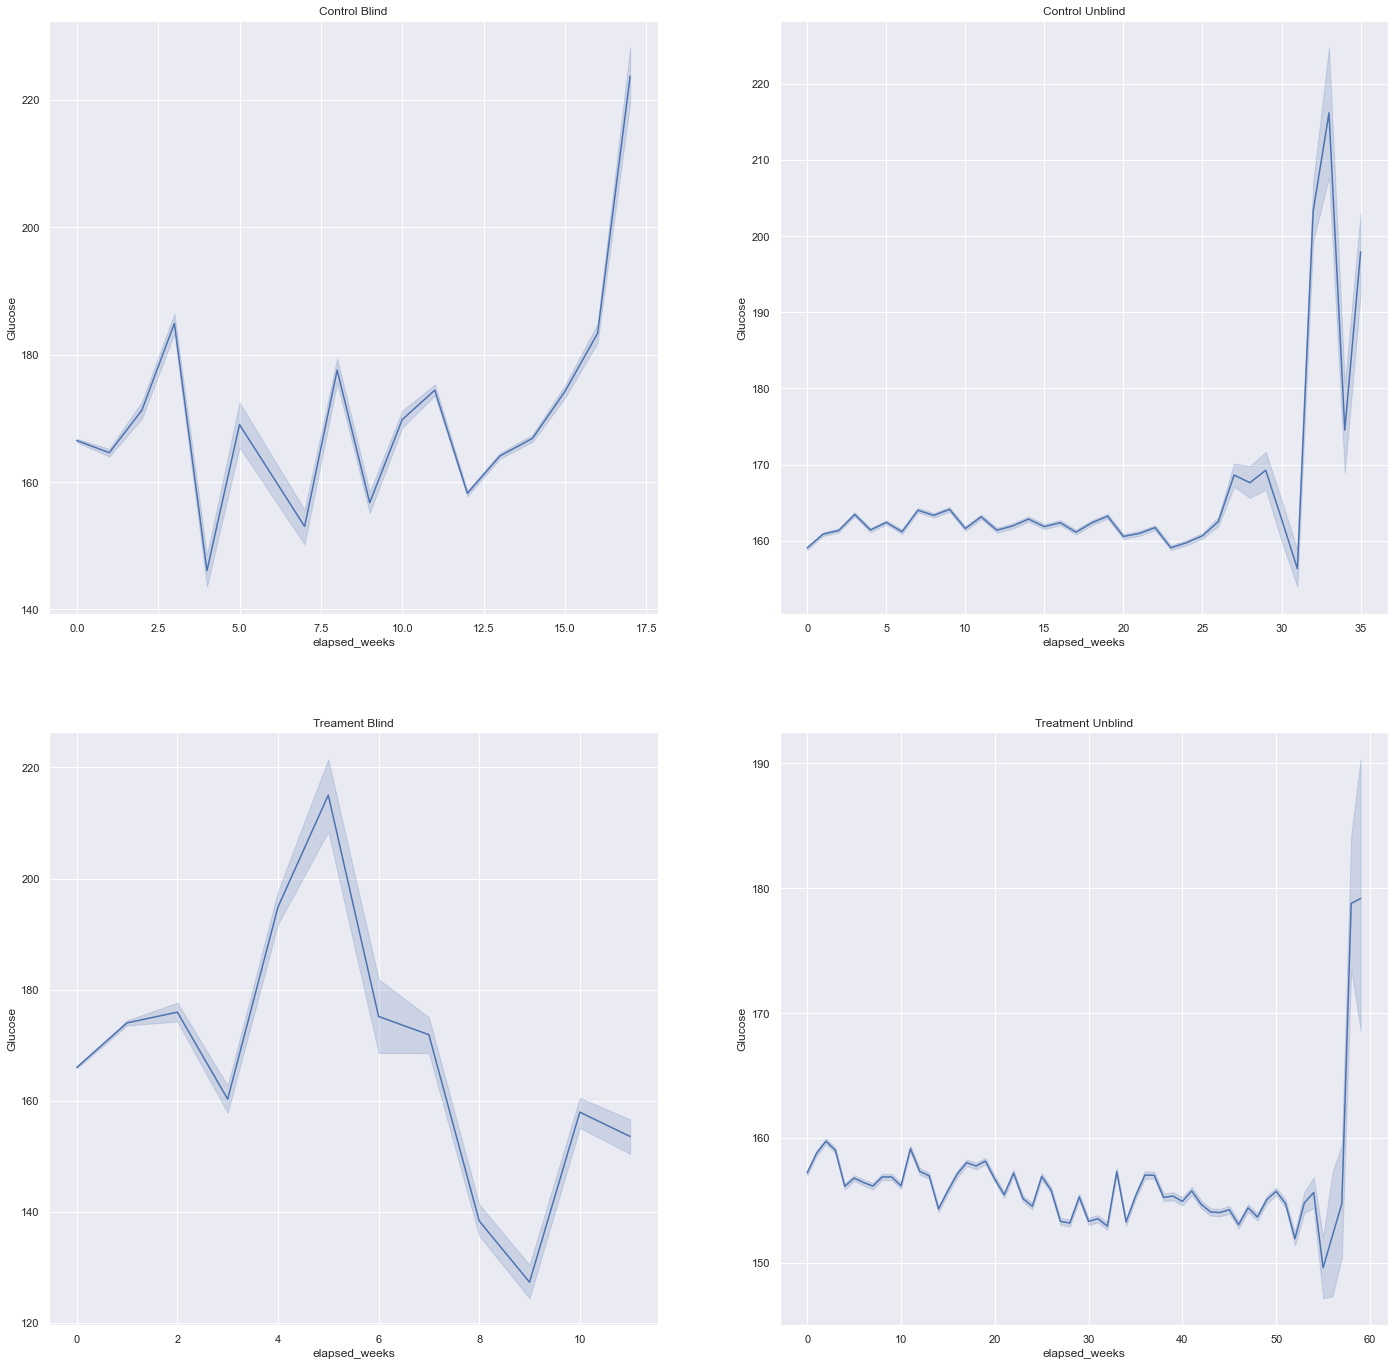

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(24, 24))
sns.lineplot(data=ctrl_blind_df, x='elapsed_weeks', y='Glucose', ax=ax[0][0]).set(title='Control Blind')
sns.lineplot(data=ctrl_unblind_df, x='elapsed_weeks', y='Glucose', ax=ax[0][1]).set(title='Control Unblind') 
sns.lineplot(data=trmt_blind_baseline_df, x='elapsed_weeks', y='Glucose', ax=ax[1][0]).set(title='Treament Blind')
sns.lineplot(data=trmt_unblind_df, x='elapsed_weeks', y='Glucose', ax=ax[1][1]).set(title='Treatment Unblind')

<AxesSubplot:xlabel='elapsed_weeks', ylabel='Glucose'>

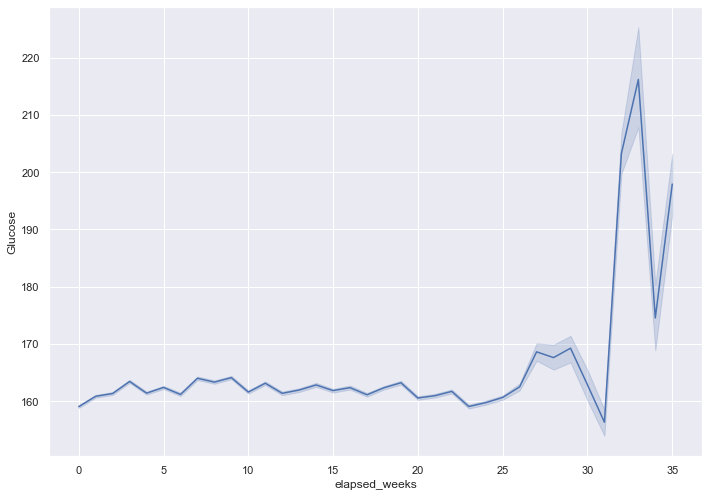

In [57]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=ctrl_unblind_df, x='elapsed_weeks', y='Glucose') 

In [ ]:
# Example barplot code
fig,ax = plt.subplots(figsize=(6,4))
sns.barplot(x=df['Col_X'],y=df['Outcome_metric'])
plt.show()

In [ ]:
cgm_treatment_summary.DeviceDtTm.head()